## Antes de começar a executar ou subir arquivo, verifique em Ambientes de Execução -> Alterar tipo, se está marcada a opção GPU.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Carregue o arquivo disponível no Canvas antes de descomprimir com a célula a seguir

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "aula2",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 187 files belonging to 2 classes.
Using 150 files for training.
Using 37 files for validation.


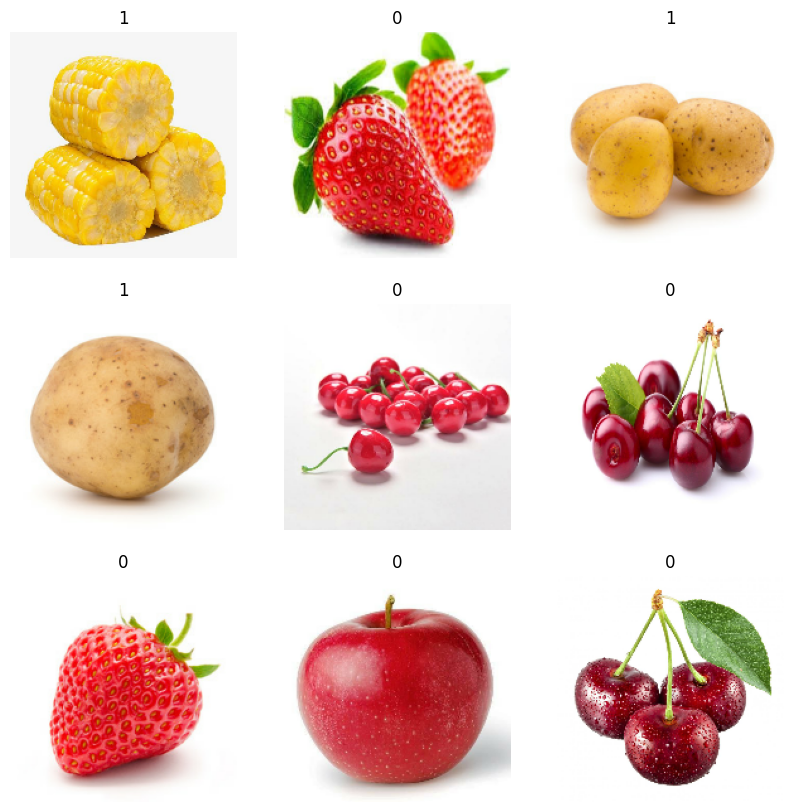

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

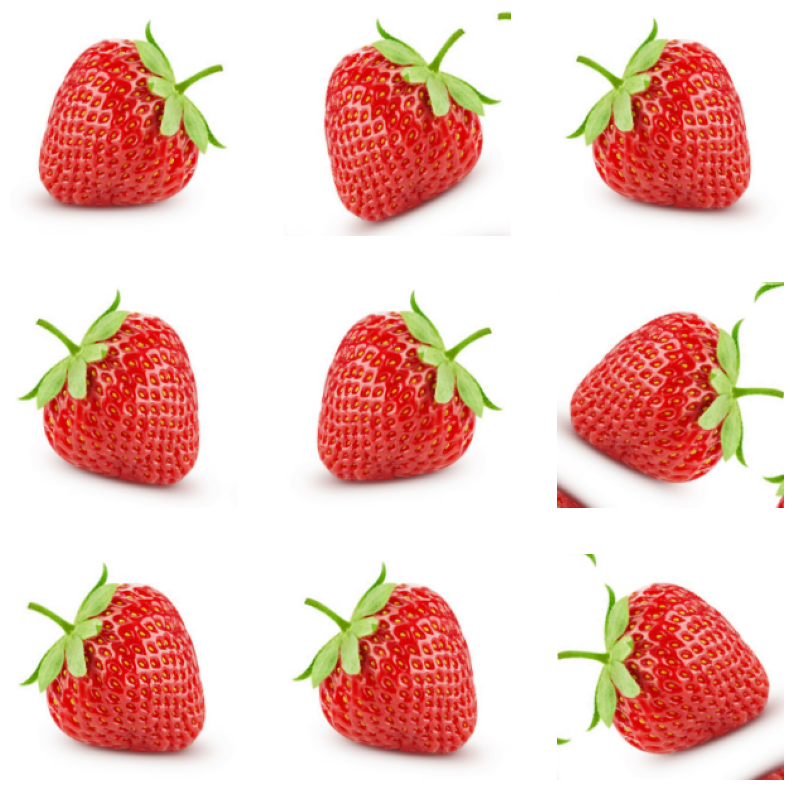

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Construindo a arquitetura do modelo

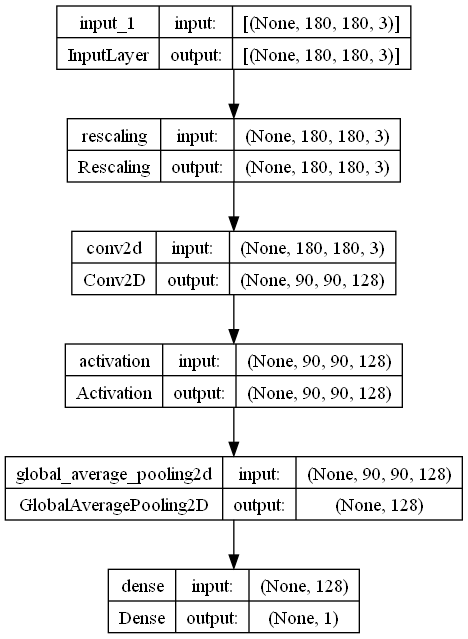

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    #x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True, to_file="model_colors.png")

## Treinando o modelo

In [9]:
epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy", # verificar no notebook de redes neurais como alterar isso para multiclasse
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/25
2/2 [==============================] - 3s 538ms/step - loss: 0.6989 - accuracy: 0.5000 - val_loss: 0.6898 - val_accuracy: 0.4865
Epoch 2/25
2/2 [==============================] - 1s 242ms/step - loss: 0.6879 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.4865
Epoch 3/25
2/2 [==============================] - 1s 239ms/step - loss: 0.6875 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.4865
Epoch 4/25
2/2 [==============================] - 2s 265ms/step - loss: 0.6848 - accuracy: 0.5000 - val_loss: 0.6835 - val_accuracy: 0.4865
Epoch 5/25
2/2 [==============================] - 1s 239ms/step - loss: 0.6784 - accuracy: 0.5000 - val_loss: 0.6775 - val_accuracy: 0.4865
Epoch 6/25
2/2 [==============================] - 1s 234ms/step - loss: 0.6734 - accuracy: 0.5333 - val_loss: 0.6754 - val_accuracy: 0.9189
Epoch 7/25
2/2 [==============================] - 1s 252ms/step - loss: 0.6745 - accuracy: 0.8400 - val_loss: 0.6755 - val_accuracy: 0.5135
Epoch 8/25
2/2 [====

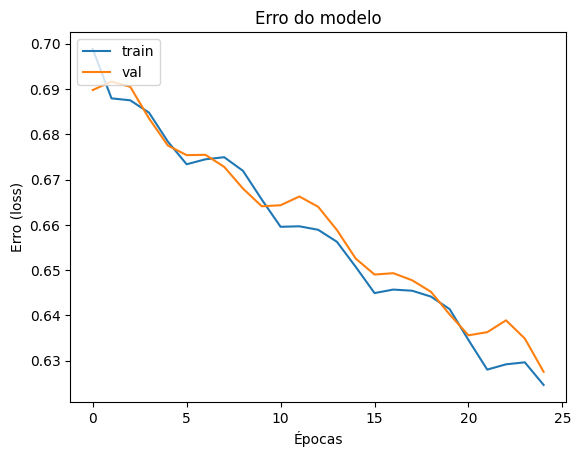

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro do modelo')
plt.ylabel('Erro (loss)')
plt.xlabel('Épocas')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
img = keras.utils.load_img(
    "aula2/red/Apple11.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% red and {100 * score:.2f}% yellow.")

1/1 [==============================] - 0s 95ms/step
This image is 46.35% red and 53.65% yellow.


## AF

Você deverá utilizar o dataset completo disponível no Canvas.
Então, você deverá elaborar 4 modelos, chamados A, B, C e D.
Para cada modelo, você deverá criar uma versão COM e SEM dropout.
Em seguida, você deverá comparar os resultados de val_loss e val_accuracy de todos modelos.

Ao final do notebook, você deverá ter uma tabela com os valores seguindo o formato de exemplo e uma descrição de qual modelo você entende que é melhor e o motivo:

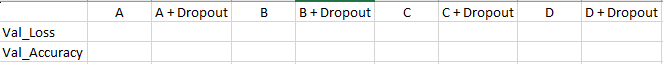

## Analisando os dados

In [12]:
image_size = (180, 180)
batch_size = 128

# Split the data into train and validation sets using 80-20 split
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "ColorfulOriginal",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 721 files belonging to 20 classes.
Using 577 files for training.
Using 144 files for validation.


In [13]:
# Set important parameters
class_names = train_ds.class_names
n_classes = len(class_names)

In [14]:
# define new model with dropout option
def make_model_veggies(input_shape, num_classes, use_dropout=False):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if use_dropout:
        x = layers.Dropout(0.5)(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


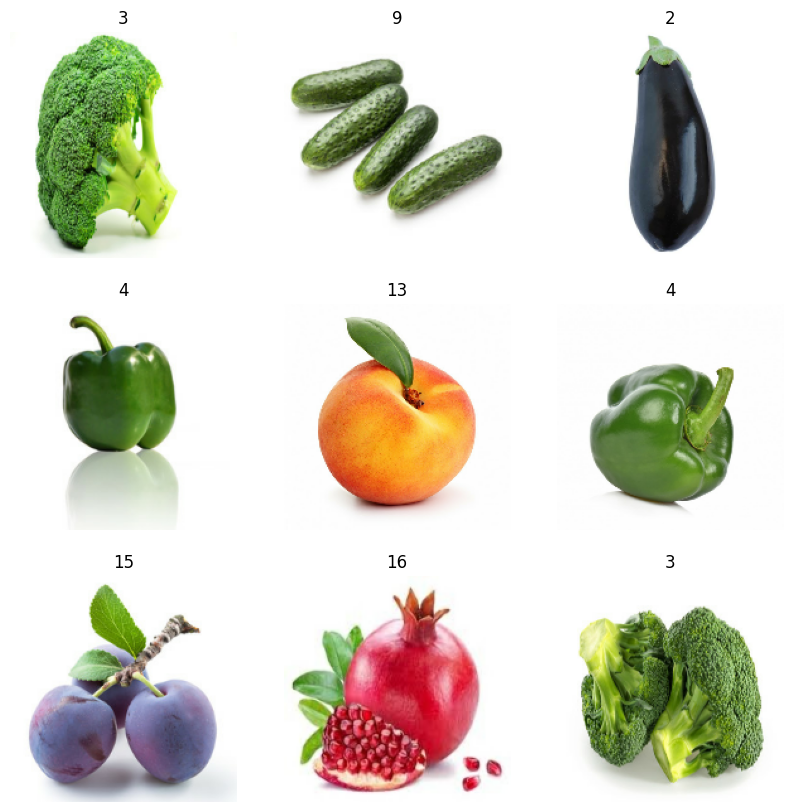

In [15]:

# Visualize dat
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data augmentation

In [16]:

# flip and rotate images to increase dataset size
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

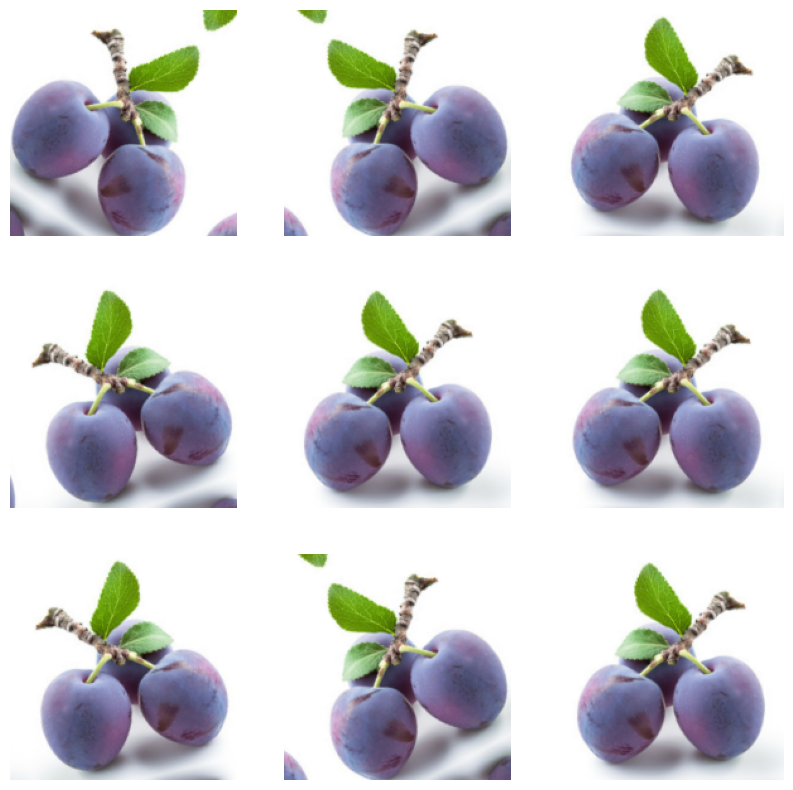

In [17]:
# visualize augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
# apply augmentation to dataset
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [19]:
# define models

models_label = ["A", "A_dropout", "B", "B_dropout", "C", "C_dropout", "D", "D_dropout"]

models = [make_model_veggies(input_shape=image_size + (3,), num_classes=n_classes, use_dropout=("dropout" in label)) for label in models_label]

models_dict = dict(zip(models_label, models))

print(models_dict)

{'A': <keras.engine.functional.Functional object at 0x0000021B241EF510>, 'A_dropout': <keras.engine.functional.Functional object at 0x0000021B28E54A90>, 'B': <keras.engine.functional.Functional object at 0x0000021B28E3AED0>, 'B_dropout': <keras.engine.functional.Functional object at 0x0000021B28E8F450>, 'C': <keras.engine.functional.Functional object at 0x0000021B28E4DF90>, 'C_dropout': <keras.engine.functional.Functional object at 0x0000021B294A2B50>, 'D': <keras.engine.functional.Functional object at 0x0000021B294693D0>, 'D_dropout': <keras.engine.functional.Functional object at 0x0000021B2949F010>}


### Rede sem dropout:

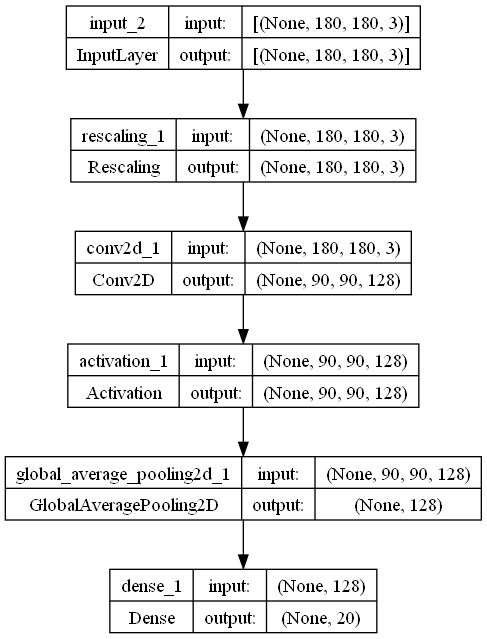

In [20]:
keras.utils.plot_model(models_dict['A'], show_shapes=True, to_file="model_veggies.png")

### Rede com dropout:

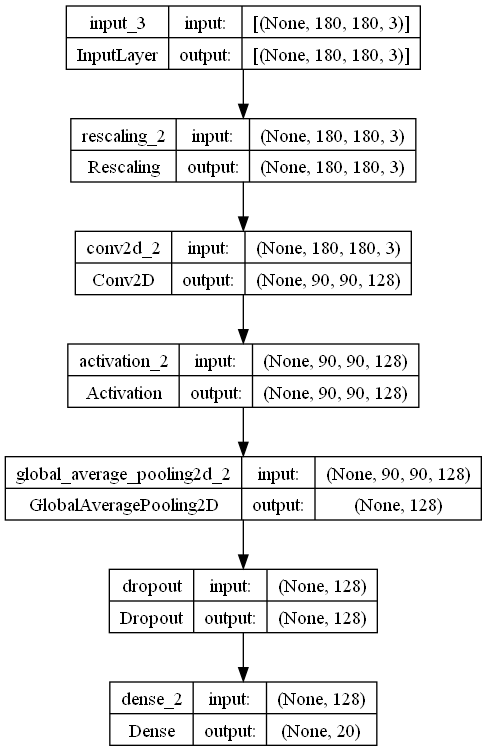

In [21]:
keras.utils.plot_model(models_dict['A_dropout'], show_shapes=True, to_file="model_veggies_dropout.png")

## Treinando a rede

In [35]:
epochs = 5000
history_list = []

# training loop
for label, model in models_dict.items():
    print(f"Training model: {label}")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy", # verificar no notebook de redes neurais como alterar isso para multiclasse
        metrics=["accuracy"],
    )
    h = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    )
    history_list.append(h)
    model.save(f"models/{label}")


Training model: A
Epoch 1/1000
5/5 [==============================] - 5s 736ms/step - loss: 1.3103 - accuracy: 0.5529 - val_loss: 1.4359 - val_accuracy: 0.5625
Epoch 2/1000
5/5 [==============================] - 4s 663ms/step - loss: 1.2971 - accuracy: 0.5390 - val_loss: 1.4415 - val_accuracy: 0.5556
Epoch 3/1000
5/5 [==============================] - 4s 599ms/step - loss: 1.2890 - accuracy: 0.5459 - val_loss: 1.4351 - val_accuracy: 0.5417
Epoch 4/1000
5/5 [==============================] - 4s 604ms/step - loss: 1.2843 - accuracy: 0.5685 - val_loss: 1.4366 - val_accuracy: 0.5694
Epoch 5/1000
5/5 [==============================] - 4s 586ms/step - loss: 1.2829 - accuracy: 0.5685 - val_loss: 1.4319 - val_accuracy: 0.5625
Epoch 6/1000
5/5 [==============================] - 4s 604ms/step - loss: 1.2794 - accuracy: 0.5633 - val_loss: 1.4184 - val_accuracy: 0.5486
Epoch 7/1000
5/5 [==============================] - 3s 575ms/step - loss: 1.2752 - accuracy: 0.5754 - val_loss: 1.4145 - val_accur

INFO:tensorflow:Assets written to: models/A\assets


INFO:tensorflow:Assets written to: models/A\assets


Training model: A_dropout
Epoch 1/1000
5/5 [==============================] - 4s 626ms/step - loss: 1.4421 - accuracy: 0.4714 - val_loss: 1.4501 - val_accuracy: 0.5069
Epoch 2/1000
5/5 [==============================] - 4s 606ms/step - loss: 1.4330 - accuracy: 0.4541 - val_loss: 1.4448 - val_accuracy: 0.5139
Epoch 3/1000
5/5 [==============================] - 4s 618ms/step - loss: 1.4243 - accuracy: 0.4714 - val_loss: 1.4422 - val_accuracy: 0.5139
Epoch 4/1000
5/5 [==============================] - 4s 608ms/step - loss: 1.4066 - accuracy: 0.4801 - val_loss: 1.4407 - val_accuracy: 0.5347
Epoch 5/1000
5/5 [==============================] - 4s 621ms/step - loss: 1.4146 - accuracy: 0.4835 - val_loss: 1.4394 - val_accuracy: 0.5347
Epoch 6/1000
5/5 [==============================] - 4s 592ms/step - loss: 1.4263 - accuracy: 0.4801 - val_loss: 1.4371 - val_accuracy: 0.5347
Epoch 7/1000
5/5 [==============================] - 4s 605ms/step - loss: 1.4351 - accuracy: 0.4905 - val_loss: 1.4360 - v

INFO:tensorflow:Assets written to: models/A_dropout\assets


INFO:tensorflow:Assets written to: models/A_dropout\assets


Training model: B
Epoch 1/1000
5/5 [==============================] - 4s 651ms/step - loss: 1.2594 - accuracy: 0.5615 - val_loss: 1.3886 - val_accuracy: 0.5694
Epoch 2/1000
5/5 [==============================] - 4s 618ms/step - loss: 1.2433 - accuracy: 0.5598 - val_loss: 1.3921 - val_accuracy: 0.5556
Epoch 3/1000
5/5 [==============================] - 4s 601ms/step - loss: 1.2443 - accuracy: 0.5563 - val_loss: 1.4012 - val_accuracy: 0.5486
Epoch 4/1000
5/5 [==============================] - 4s 604ms/step - loss: 1.2374 - accuracy: 0.5702 - val_loss: 1.3916 - val_accuracy: 0.5764
Epoch 5/1000
5/5 [==============================] - 4s 615ms/step - loss: 1.2376 - accuracy: 0.5771 - val_loss: 1.3880 - val_accuracy: 0.5833
Epoch 6/1000
5/5 [==============================] - 4s 619ms/step - loss: 1.2350 - accuracy: 0.5667 - val_loss: 1.3883 - val_accuracy: 0.5417
Epoch 7/1000
5/5 [==============================] - 4s 643ms/step - loss: 1.2324 - accuracy: 0.5754 - val_loss: 1.3893 - val_accur

INFO:tensorflow:Assets written to: models/B\assets


INFO:tensorflow:Assets written to: models/B\assets


Training model: B_dropout
Epoch 1/1000
5/5 [==============================] - 5s 737ms/step - loss: 1.4231 - accuracy: 0.4697 - val_loss: 1.4143 - val_accuracy: 0.5278
Epoch 2/1000
5/5 [==============================] - 4s 610ms/step - loss: 1.4139 - accuracy: 0.4957 - val_loss: 1.4130 - val_accuracy: 0.5486
Epoch 3/1000
5/5 [==============================] - 4s 653ms/step - loss: 1.4070 - accuracy: 0.5095 - val_loss: 1.4119 - val_accuracy: 0.5486
Epoch 4/1000
5/5 [==============================] - 4s 616ms/step - loss: 1.4214 - accuracy: 0.4939 - val_loss: 1.4105 - val_accuracy: 0.5347
Epoch 5/1000
5/5 [==============================] - 4s 622ms/step - loss: 1.4143 - accuracy: 0.4887 - val_loss: 1.4079 - val_accuracy: 0.5208
Epoch 6/1000
5/5 [==============================] - 4s 620ms/step - loss: 1.4179 - accuracy: 0.4853 - val_loss: 1.4054 - val_accuracy: 0.5486
Epoch 7/1000
5/5 [==============================] - 4s 614ms/step - loss: 1.3940 - accuracy: 0.5095 - val_loss: 1.4063 - v

## Plotando os resultados

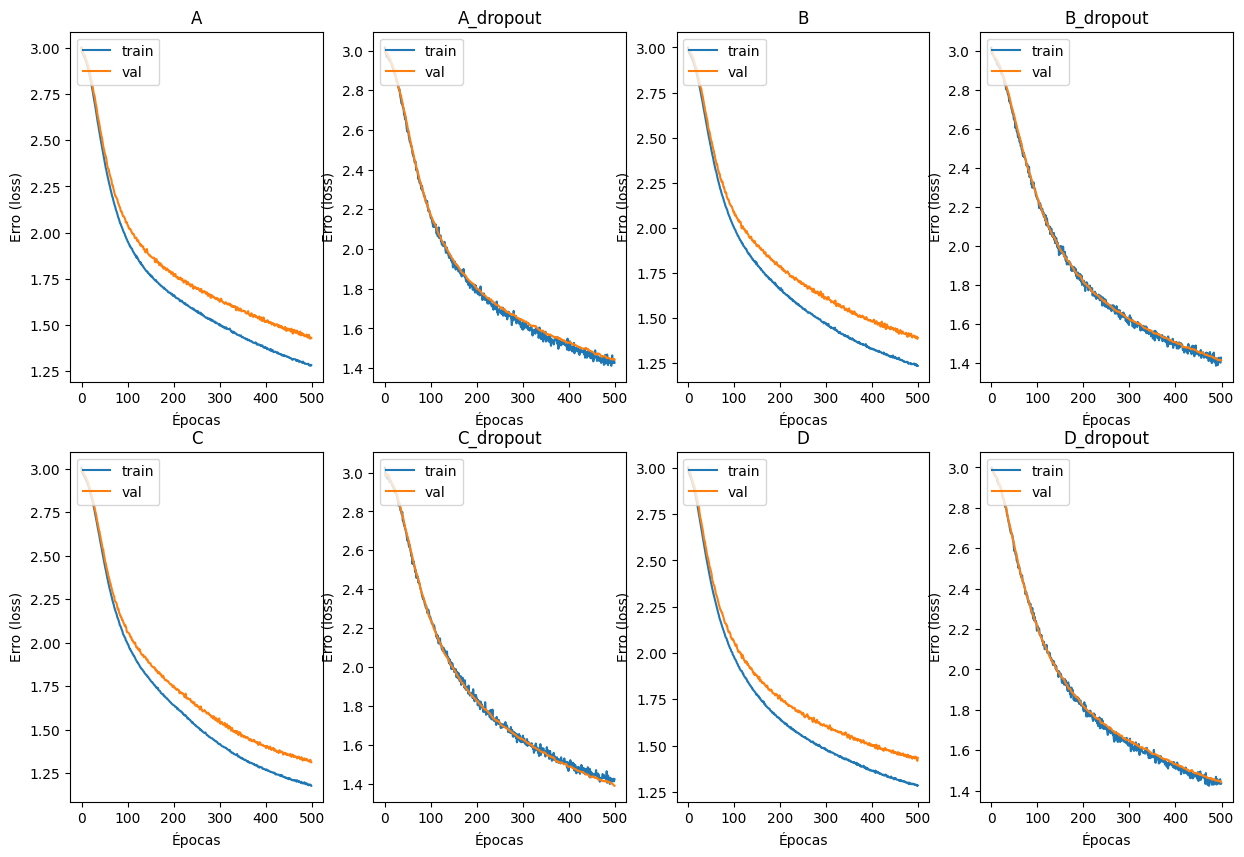

In [26]:

fig, axs = plt.subplots(2, 4, figsize=(15, 10))  # Create a grid of 2 rows and 4 columns


for i in range(2):
    for j in range(4):
        axs[i, j].plot(history_list[i*4+j].history['loss'])
        axs[i, j].plot(history_list[i*4+j].history['val_loss'])
        axs[i, j].set_title('Erro do modelo')
        axs[i, j].set_ylabel('Erro (loss)')
        axs[i, j].set_xlabel('Épocas')
        axs[i, j].legend(['train', 'val'], loc='upper left')
        axs[i, j].set_title(models_label[i*4+j])


plt.show()



Podemos observar, que no geral, a rede sem dropout apresentou melhores resultados, entretando, observando os gráficos de loss e accuracy, podemos ver que a rede com dropout apresentou um menor overfitting, ou seja, ela generalizou melhor os dados. Isso pode ser observado  pela proximidade entre as curvas de treino e validação.

## Teste da rede

In [34]:
img = keras.utils.load_img(
    "ColorfulOriginal/Brinjal/Brinjal1.jpg", target_size=image_size
)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

for label, model in models_dict.items():
    print(f"Model: {label}")
    predictions = model.predict(img_array)
    for score, names in zip(predictions[0], class_names):
        print(
            f"This image is {100 * float(score):.2f} % {names}"
        )

Model: A
1/1 [==============================] - 0s 25ms/step
This image is 1.32 % Apple
This image is 0.16 % Banana
This image is 56.69 % Brinjal
This image is 0.18 % Broccoli
This image is 1.19 % CapsicumGreen
This image is 0.36 % Carrot
This image is 4.33 % Cherry
This image is 4.17 % ChilliGreen
This image is 0.04 % Corn
This image is 7.97 % Cucumber
This image is 4.99 % LadyFinger
This image is 0.01 % Lemon
This image is 0.00 % Orange
This image is 0.07 % Peach
This image is 0.09 % Pear
This image is 17.42 % Plum
This image is 0.21 % Pomegranate
This image is 0.16 % Potato
This image is 0.50 % Strawberry
This image is 0.15 % Tomato
Model: A_dropout
1/1 [==============================] - 0s 26ms/step
This image is 1.76 % Apple
This image is 0.14 % Banana
This image is 59.67 % Brinjal
This image is 0.73 % Broccoli
This image is 1.59 % CapsicumGreen
This image is 0.33 % Carrot
This image is 3.92 % Cherry
This image is 2.46 % ChilliGreen
This image is 0.04 % Corn
This image is 5.35 % C

In [29]:
import pandas as pd

# defines rows as val_loss and val_accuracy and columns as model names
data = {
    "model": models_label,
    "val_loss": [h.history["val_loss"][-1] for h in history_list],
    "val_accuracy": [h.history["val_accuracy"][-1] for h in history_list],

}

# Create a DataFrame
df = pd.DataFrame(data)
df = df.set_index('model')
# Use the DataFrame's style property to customize the look of the DataFrame
df.T.style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')])])




model,A,A_dropout,B,B_dropout,C,C_dropout,D,D_dropout
val_loss,1.428991,1.442794,1.390326,1.411200,1.313894,1.388897,1.433640,1.441436
val_accuracy,0.590278,0.527778,0.569444,0.548611,0.625000,0.527778,0.562500,0.513889
